# Прогноз оттока клиентов

 Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.\
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.\
Необходимо построить модель с предельно большим значением F1-меры. Для успешной сдачи проекта нужно довести метрику до 0.59

**Признаки**
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

**Целевой признак**
- Exited — факт ухода клиента

## Анализ данных

In [1]:
 pip install imbalanced-learn -U

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score, roc_curve, roc_auc_score  
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

In [3]:
try:
    df = pd.read_csv('Churn.csv')  # загрузим датасет 
except:
    df = pd.read_csv('/datasets/Churn.csv')

In [4]:
df.head()  # выведем на экран первые 5 строк для ознакомления

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [5]:
df.info()  # посмотрим на типы данных и количество пропусков 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


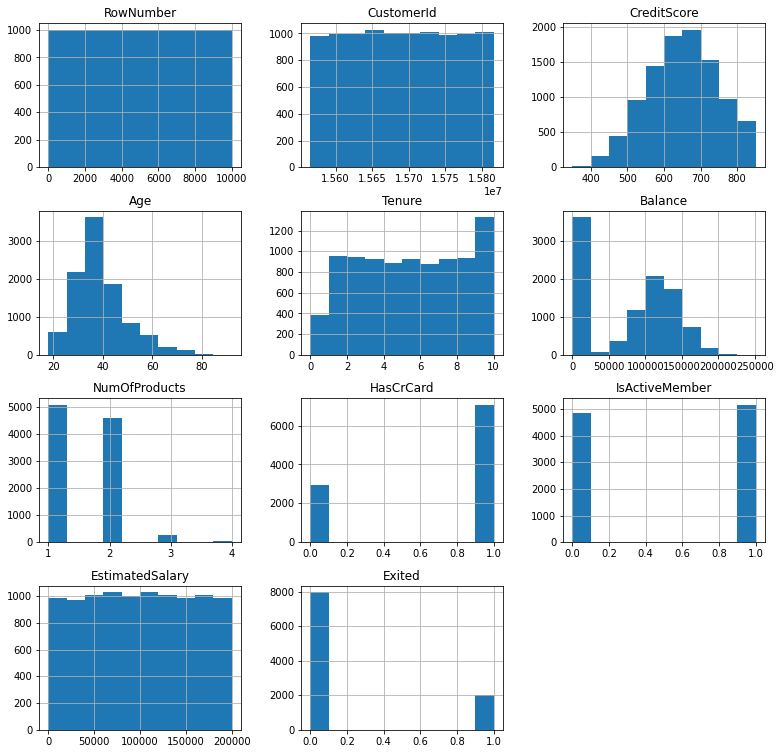

In [6]:
df.hist(figsize=(13,13));

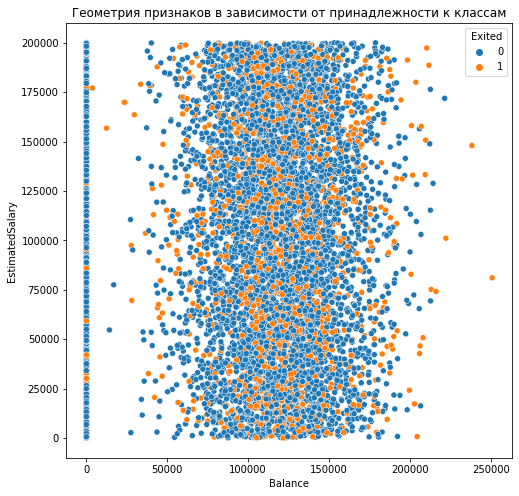

In [7]:
plt.figure(figsize=(8,8))
sns.scatterplot(x='Balance', y='EstimatedSalary', hue='Exited', data=df)
plt.title("Геометрия признаков в зависимости от принадлежности к классам");

In [8]:
df['Exited'].value_counts() #  посмотрим на соотношение классов в целевом признаке

0    7963
1    2037
Name: Exited, dtype: int64

Имеем датасет с 10000 объектов, 13-ю признаками, из них 3 - категориальные; в столбце 'Tenure' имеется 909 пропусков.\
Целевой признак имеет два значения: 0 - клиент остался, 1 - клиент ушел. Перед нами стоит **задача бинарной классификации.**

Соотношение классов целевого признака примерно 1:4, имеется дисбаланс классов. Исходя из последнего графика можно предположить, что логистическая регрессия в данной задаче даст наихудший результат, так как признаки не поддаются разделению гиперплоскостью.

Переименуем столбцы в соответствии со snake_case:

In [9]:
df.columns = ['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited']

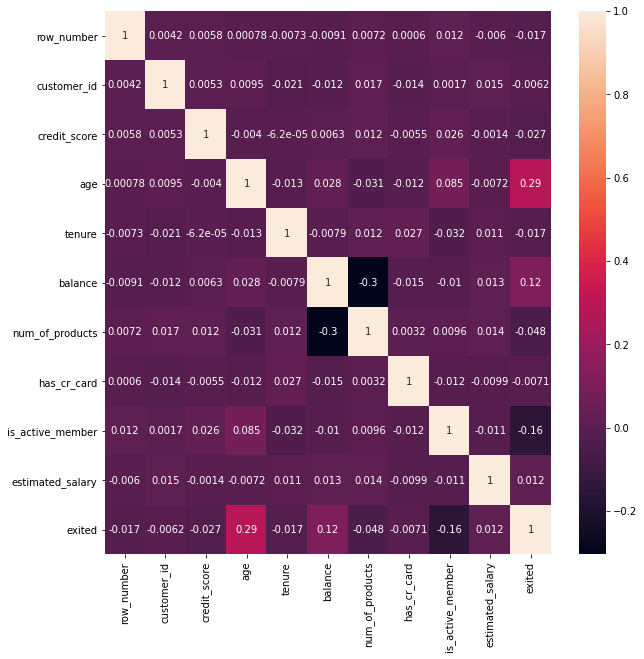

In [10]:
coor_matrix = df.corr()  # посмотрим на матрицу корреляции признаков 
plt.figure(figsize=(10,10))
sns.heatmap(coor_matrix, annot=True);

Между признаками выявлена слабая и умеренная(между *'num_of_products'* и *'balance'*) корреляция. Мультиколлинеарности не выявлено, все признаки оставляем.

In [11]:
df['geography'].value_counts()  # уникальные значения столбца 'geography'

France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64

In [12]:
df['tenure'].sort_values().unique() #  уникальные значения столбца с пропусками 'tenure'

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., nan])

In [13]:
df['age'].sort_values().unique() # посмотрим на возраст, нет ли ошибок в данных

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       88, 92])

In [14]:
df.duplicated().sum() # проверка на дубликаты

0

 Перед обучением модели необходимо избавиться от пропусков в столбце 'tenure'. 
Удалим пропуски, чтобы не искажать данные, так как достоверно восстановить их нельзя. В нашем датасете пропусков не больше 10%:

In [15]:
print('Процент пропусков:', df['tenure'].isna().sum()/df.shape[0]*100,'%' )

Процент пропусков: 9.09 %


In [16]:
df_drop = df.dropna()
df_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        9091 non-null   int64  
 1   customer_id       9091 non-null   int64  
 2   surname           9091 non-null   object 
 3   credit_score      9091 non-null   int64  
 4   geography         9091 non-null   object 
 5   gender            9091 non-null   object 
 6   age               9091 non-null   int64  
 7   tenure            9091 non-null   float64
 8   balance           9091 non-null   float64
 9   num_of_products   9091 non-null   int64  
 10  has_cr_card       9091 non-null   int64  
 11  is_active_member  9091 non-null   int64  
 12  estimated_salary  9091 non-null   float64
 13  exited            9091 non-null   int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.0+ MB


## Подготовка признаков для обучения модели

#### 1. Определим признаки, необходимые для обучения модели

Из набора признаков удалим *'row_number'*,*'customer_id'* и *'surname'*. Это уникальные идентификационные данные, которые не помогут модели в принятии решений классификации. Также, из набора признаков удалим целевой признак *'exited'*.

In [17]:
features = df_drop.drop(['row_number','customer_id','surname','exited'],axis=1)
target = df_drop['exited']

#### 2. Разделим датасет на тренировочную, валидационную и тестовую выборки

In [18]:
features_all, features_test, target_all, target_test = train_test_split(
        features, target, test_size=0.2, random_state=123
    )

In [19]:
features_train, features_valid, target_train, target_valid = train_test_split(
        features_all, target_all, test_size=0.25, random_state=123
)  # разделение тренировочной выборки на тренировочную и валидационную

print(f'Размер тренировочной выборки:{features_train.shape}') 
print(f'Размер валидационной выборки:{features_valid.shape}')
print(f'Размер тестовой выборки:{features_test.shape}')

Размер тренировочной выборки:(5454, 10)
Размер валидационной выборки:(1818, 10)
Размер тестовой выборки:(1819, 10)


#### 3. Масштабируем признаки для корректной работы алгоритма

In [20]:
def scaler(features_train, features_valid, features_test):  # функция масштабирования признаков
    scaler = StandardScaler()
    scaler.fit(features_train) 
    features_train_scaled = scaler.transform(features_train)
    features_valid_scaled = scaler.transform(features_valid)
    features_test_scaled = scaler.transform(features_test)
    return features_train_scaled, features_valid_scaled, features_test_scaled

In [21]:
  # отбор столбцов для масштабирования
columns = ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary']
features_train[columns], features_valid[columns], features_test[columns] = scaler(
    features_train[columns], features_valid[columns], features_test[columns]
)  # применение функции масштабирования
features_train

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
5400,0.838488,France,Female,-0.843042,-0.000758,-1.222660,2,1,0,1.545552
1767,1.693581,France,Female,0.852020,0.688238,-1.222660,2,1,1,0.560133
2847,-1.242579,Spain,Male,-0.089681,0.688238,0.371065,2,1,0,-0.181020
1475,-0.160836,France,Male,-1.219722,1.032736,-1.222660,1,1,0,-1.372303
9265,0.261559,France,Female,-0.089681,-1.378750,0.437699,1,0,0,-1.366948
...,...,...,...,...,...,...,...,...,...,...
6622,-0.933510,France,Female,0.381170,-1.378750,-1.222660,1,0,1,-0.244011
1998,-0.480208,France,Male,0.381170,-0.000758,0.817716,1,1,1,-1.411915
9868,0.704558,France,Female,0.381170,-1.723247,0.264132,1,1,0,1.163378
5144,-1.695881,France,Female,-1.313892,-0.689754,0.923759,1,1,1,0.219175


#### 4. OHE-кодирование категориальных признаков

Для работы моделей классификации категориальные признаки необходимо перевести в числовые. Воспользуемся методом прямого кодирования(One-Hot Encoding). Данный метод лучше всего подходит для линейных моделей.  При этом появляются новые зависимые столбцы. В функции укажем drop='first', чтобы избавиться от лишних зависимых столбцов. 

In [22]:
enc = OneHotEncoder(drop='first')
enc.fit(features_train[['geography','gender']]) 
features_train_enc = pd.DataFrame(enc.transform(features_train[['geography','gender']]).toarray())
features_valid_enc = pd.DataFrame(enc.transform(features_valid[['geography','gender']]).toarray())
features_test_enc = pd.DataFrame(enc.transform(features_test[['geography','gender']]).toarray())

features_train_enc.columns = ['geography_germany','geography_spain', 'gender_male']
features_valid_enc.columns = ['geography_germany','geography_spain', 'gender_male']
features_test_enc.columns = ['geography_germany','geography_spain', 'gender_male']

In [23]:
features_train = features_train.drop(columns=['geography','gender']).reset_index(drop=True)
features_valid = features_valid.drop(columns=['geography','gender']).reset_index(drop=True)
features_test = features_test.drop(columns=['geography','gender']).reset_index(drop=True)

In [24]:
features_test_enc

,geography_germany,geography_spain,gender_male
0,1.0,0.0,1.0
1,0.0,0.0,1.0
2,1.0,0.0,0.0
3,0.0,1.0,1.0
4,0.0,1.0,1.0
...,...,...,...
1814,0.0,0.0,0.0
1815,1.0,0.0,0.0
1816,0.0,1.0,1.0
1817,0.0,0.0,0.0


In [25]:
features_train = features_train.join(features_train_enc)
features_valid = features_valid.join(features_valid_enc)
features_test = features_test.join(features_test_enc)
features_train

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_germany,geography_spain,gender_male
0,0.838488,-0.843042,-0.000758,-1.222660,2,1,0,1.545552,0.0,0.0,0.0
1,1.693581,0.852020,0.688238,-1.222660,2,1,1,0.560133,0.0,0.0,0.0
2,-1.242579,-0.089681,0.688238,0.371065,2,1,0,-0.181020,0.0,1.0,1.0
3,-0.160836,-1.219722,1.032736,-1.222660,1,1,0,-1.372303,0.0,0.0,1.0
4,0.261559,-0.089681,-1.378750,0.437699,1,0,0,-1.366948,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
5449,-0.933510,0.381170,-1.378750,-1.222660,1,0,1,-0.244011,0.0,0.0,0.0
5450,-0.480208,0.381170,-0.000758,0.817716,1,1,1,-1.411915,0.0,0.0,1.0
5451,0.704558,0.381170,-1.723247,0.264132,1,1,0,1.163378,0.0,0.0,0.0
5452,-1.695881,-1.313892,-0.689754,0.923759,1,1,1,0.219175,0.0,0.0,0.0


In [26]:
print(f'Размер тренировочной выборки:{features_train.shape}') 
print(f'Размер валидационной выборки:{features_valid.shape}')
print(f'Размер тестовой выборки:{features_test.shape}')

Размер тренировочной выборки:(5454, 11)
Размер валидационной выборки:(1818, 11)
Размер тестовой выборки:(1819, 11)


##   Анализ моделей без учета дисбаланса классов

In [27]:
def model_auc(model, features_valid, target_valid):  # функция для вычисления roc_auc_score
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    return roc_auc_score(target_valid, probabilities_one_valid)

In [28]:
def model_fitting(features_train, target_train, features_valid, model):  # функция обучения модели
    model = model(random_state=123)
    model.fit(features_train, target_train)
    predict = model.predict(features_valid)
    report = classification_report(target_valid, predict)
    auc = model_auc(model, features_valid, target_valid)
    print(report)
    return (f'Метрика roc_auc_score: {auc}')

In [29]:
print(model_fitting(features_train, target_train, features_valid, LogisticRegression)) # модель "Логистическая регрессия"

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      1462
           1       0.48      0.18      0.26       356

    accuracy                           0.80      1818
   macro avg       0.65      0.56      0.57      1818
weighted avg       0.76      0.80      0.76      1818

Метрика roc_auc_score: 0.750812723835288


In [30]:
print(model_fitting(features_train, target_train, features_valid, DecisionTreeClassifier))  # модель "Дерево решений"

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1462
           1       0.47      0.46      0.47       356

    accuracy                           0.79      1818
   macro avg       0.67      0.67      0.67      1818
weighted avg       0.79      0.79      0.79      1818

Метрика roc_auc_score: 0.667409582071658


In [31]:
print(model_fitting(features_train, target_train, features_valid, RandomForestClassifier))  # модель "Случайный лес"

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1462
           1       0.76      0.41      0.54       356

    accuracy                           0.86      1818
   macro avg       0.82      0.69      0.73      1818
weighted avg       0.85      0.86      0.84      1818

Метрика roc_auc_score: 0.8360968505510383


 **Вывод.** Лучшая модель в данном исследовании - модель RandomForestClassifier(пока самая обычная, без подбора гиперпараметров) с метриками по классу 1: precision - 0,76, recall - 0,41, f1-score -  0,54. roc_auc_score -  0.8360968505510383

#### 3. Подбор гиперпараметров для модели случайного леса

Лучшей моделью в предыдущих исследованиях стала модель RandomForestClassifier. Подберем для нее оптимальные гиперпараметры.

In [32]:
%%time 
best_model = None
best_result = 0
for est in range(10, 61, 10):
    for depth in range (1, 16):
        model = RandomForestClassifier(random_state=123, n_estimators=est,max_depth=depth) 
        model.fit(features_train,target_train) 
        pred = model.predict(features_valid)
        result = f1_score(target_valid, pred)
        if result > best_result:
            best_model = model 
            best_result = result
            best_est = est
            best_depth = depth
roc = model_auc(best_model, features_valid, target_valid)       
print("F1-мера наилучшей модели на валидационной выборке:", best_result)
print("Параметры лучшей модели:", "число деревьев -", best_est, "глубина дерева -", best_depth)
print("roc_auc_score:",roc)

F1-мера наилучшей модели на валидационной выборке: 0.5471014492753623
Параметры лучшей модели: число деревьев - 50 глубина дерева - 15
roc_auc_score: 0.8293971625755083
CPU times: user 16.4 s, sys: 62.6 ms, total: 16.5 s
Wall time: 16.5 s


 **Вывод.** Возьмем за наилучшую модель классификатора - RandomForestClassifier с параметрами max_depth=15, n_estimators=50 и метриками f1_score = 0.5471014492753623 и roc_auc_score = 0.8293971625755083

##   Анализ моделей с балансировкой классов и выбор наилучшей

### 1. Взвешивание классов

In [33]:
def model_weight(features_train, target_train, features_valid, model):  # функция обучения модели c взвешенными классами
    model = model(class_weight="balanced", random_state=123)
    model.fit(features_train, target_train)
    predict = model.predict(features_valid)
    report = classification_report(target_valid, predict)
    auc = model_auc(model, features_valid, target_valid)
    print(report)
    return (f'Метрика roc_auc_score: {auc}')

In [34]:
print(model_weight(features_train, target_train, features_valid, LogisticRegression))  # модель "Логистическая регрессия"

              precision    recall  f1-score   support

           0       0.90      0.71      0.79      1462
           1       0.36      0.69      0.47       356

    accuracy                           0.70      1818
   macro avg       0.63      0.70      0.63      1818
weighted avg       0.80      0.70      0.73      1818

Метрика roc_auc_score: 0.7523670821869382


In [35]:
print(model_weight(features_train, target_train, features_valid, DecisionTreeClassifier))  # модель "Дерево решений"

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1462
           1       0.45      0.42      0.43       356

    accuracy                           0.79      1818
   macro avg       0.66      0.65      0.65      1818
weighted avg       0.78      0.79      0.78      1818

Метрика roc_auc_score: 0.6473681581333866


In [36]:
print(model_weight(features_train, target_train, features_valid, RandomForestClassifier))  # модель "Случайный лес"

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1462
           1       0.78      0.39      0.52       356

    accuracy                           0.86      1818
   macro avg       0.82      0.68      0.72      1818
weighted avg       0.85      0.86      0.84      1818

Метрика roc_auc_score: 0.8356799213022025


In [37]:
%%time 
best_model = None
best_result = 0
for est in range(10, 101, 10):
    for depth in range (1, 16):
        model_weight = RandomForestClassifier(class_weight='balanced',random_state=123, n_estimators=est,max_depth=depth) 
        model_weight.fit(features_train, target_train) 
        pred = model_weight.predict(features_valid)
        result = f1_score(target_valid, pred)
        if result > best_result:
            best_model_weight = model_weight 
            best_result = result
            best_est = est
            best_depth = depth
roc = model_auc(best_model_weight, features_valid, target_valid)       
print("F1-мера наилучшей модели на валидационной выборке:", best_result)
print("Параметры лучшей модели:", "число деревьев -", best_est, "глубина дерева -", best_depth)
print("roc_auc_score:",roc)

F1-мера наилучшей модели на валидационной выборке: 0.6021180030257185
Параметры лучшей модели: число деревьев - 80 глубина дерева - 11
roc_auc_score: 0.8464797337801072
CPU times: user 41.7 s, sys: 262 ms, total: 42 s
Wall time: 42.1 s


**Вывод** По сравнению с предыдущими моделями, в данных моделях мы учли дисбаланс классов с помощью указания параметра class_weight="balanced". F1-мера стала выше. 

Наилучшая медель - RandomForestClassifier(max_depth=11, n_estimators=80), f1_score лучшей модели: 0.6021180030257185, roc_auc_score: 0.8464797337801072

### 2. Уменьшение выборки

In [38]:
rus = RandomUnderSampler(random_state=123)
features_downsampled, target_downsampled = rus.fit_resample(features_train,target_train)
print(features_downsampled.shape)
print(target_downsampled.shape)

(2208, 11)
(2208,)


In [39]:
 # модель "Логистическая регрессия"
print(model_fitting(features_downsampled, target_downsampled, features_valid, LogisticRegression)) 

              precision    recall  f1-score   support

           0       0.90      0.71      0.79      1462
           1       0.36      0.69      0.47       356

    accuracy                           0.70      1818
   macro avg       0.63      0.70      0.63      1818
weighted avg       0.80      0.70      0.73      1818

Метрика roc_auc_score: 0.7502862786086475


In [40]:
# модель "Дерево решений"
print(model_fitting(features_downsampled, target_downsampled, features_valid, DecisionTreeClassifier))

              precision    recall  f1-score   support

           0       0.90      0.69      0.78      1462
           1       0.35      0.70      0.47       356

    accuracy                           0.69      1818
   macro avg       0.63      0.69      0.62      1818
weighted avg       0.79      0.69      0.72      1818

Метрика roc_auc_score: 0.6909958652915046


In [41]:
# модель "Случайный лес"
print(model_fitting(features_downsampled, target_downsampled, features_valid, RandomForestClassifier))

              precision    recall  f1-score   support

           0       0.92      0.77      0.84      1462
           1       0.43      0.73      0.54       356

    accuracy                           0.76      1818
   macro avg       0.68      0.75      0.69      1818
weighted avg       0.83      0.76      0.78      1818

Метрика roc_auc_score: 0.8361400805422771


Подберем гиперпараметры для модели случайного леса:

In [42]:
%%time 
best_model = None
best_result = 0
for est in range(10, 101, 10):
    for depth in range (1, 16):
        model = RandomForestClassifier(random_state=123, n_estimators=est,max_depth=depth) 
        model.fit(features_downsampled,target_downsampled) 
        pred = model.predict(features_valid)
        result = f1_score(target_valid, pred)
        if result > best_result:
            best_model = model 
            best_result = result
            best_est = est
            best_depth = depth
roc = model_auc(best_model, features_valid, target_valid)       
print("F1-мера наилучшей модели на валидационной выборке:", best_result)
print("Параметры лучшей модели:", "число деревьев -", best_est, "глубина дерева -", best_depth)
print("roc_auc_score:",roc)

F1-мера наилучшей модели на валидационной выборке: 0.5600858369098712
Параметры лучшей модели: число деревьев - 30 глубина дерева - 9
roc_auc_score: 0.8352399360580397
CPU times: user 24.9 s, sys: 104 ms, total: 25 s
Wall time: 25 s


**Вывод**  В данном методе балансировки классов лучшая модель:
RandomForestClassifier(max_depth=9, n_estimators=30), f1_score лучшей модели: 0.5600858369098712, roc_auc_score: 0.8352399360580397

### 3. Увеличение выборки

In [43]:
smote = SMOTE()
features_upsampled, target_upsampled = smote.fit_resample(features_train,target_train)
print(features_upsampled.shape)
print(target_upsampled.shape)

(8700, 11)
(8700,)


In [44]:
 # модель "Логистическая регрессия"
print(model_fitting(features_upsampled, target_upsampled, features_valid, LogisticRegression))

              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1462
           1       0.37      0.66      0.48       356

    accuracy                           0.72      1818
   macro avg       0.64      0.70      0.64      1818
weighted avg       0.80      0.72      0.74      1818

Метрика roc_auc_score: 0.7542480671390583


In [45]:
# модель "Дерево решений"
print(model_fitting(features_upsampled, target_upsampled, features_valid, DecisionTreeClassifier))

              precision    recall  f1-score   support

           0       0.88      0.85      0.87      1462
           1       0.46      0.54      0.50       356

    accuracy                           0.79      1818
   macro avg       0.67      0.69      0.68      1818
weighted avg       0.80      0.79      0.79      1818

Метрика roc_auc_score: 0.6923350343534331


In [46]:
# модель "Случайный лес"
print(model_fitting(features_upsampled, target_upsampled, features_valid, RandomForestClassifier))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1462
           1       0.59      0.53      0.55       356

    accuracy                           0.83      1818
   macro avg       0.74      0.72      0.73      1818
weighted avg       0.83      0.83      0.83      1818

Метрика roc_auc_score: 0.8365262684640095


Подберем гиперпараметры для модели случайного леса:

In [47]:
%%time
best_model = None
best_result = 0
for est in range(10, 61, 10):
    for depth in range (1, 16):
        model = RandomForestClassifier(random_state=12, n_estimators=est,max_depth=depth) 
        model.fit(features_upsampled,target_upsampled) 
        pred = model.predict(features_valid)
        result = f1_score(target_valid, pred)
        if result > best_result:
            best_model_up = model 
            best_result = result
            best_est = est
            best_depth = depth
roc = model_auc(best_model_up, features_valid, target_valid)       
print("F1-мера наилучшей модели на валидационной выборке:", best_result)
print("Параметры лучшей модели:", "число деревьев -", best_est, "глубина дерева -", best_depth)
print("roc_auc_score:",roc)

F1-мера наилучшей модели на валидационной выборке: 0.5870393900889455
Параметры лучшей модели: число деревьев - 30 глубина дерева - 8
roc_auc_score: 0.8414708187952474
CPU times: user 25.5 s, sys: 108 ms, total: 25.6 s
Wall time: 25.8 s


**Вывод**  Лучшая модель - модель случайного леса RandomForestClassifier с параметрами: максимальная глубина дерева = 8, число деревьев = 30. Метрики:
- F1-мера лучшей модели: 0.5944584382871536,
- roc_auc_score: 0.8449858974161916

## Тестирование лучшей модели

В результате исследования мы получили лучшую модель с самой высокой F1-мерой выше 0,59 на валидационной выборке:
- модель "Случайный лес" с балансированием классов методом взвешивания классов: F1-мера = 0.6021180030257185;
 
Проверим  модель на тестовой выборке.

In [48]:
print('Метрика F1-мера на тестовой выборке:', f1_score(target_test, best_model_weight.predict(features_test)))
print(classification_report(target_test, best_model_weight.predict(features_test)))
print("roc_auc_score:",model_auc(best_model_weight, features_test, target_test))

Метрика F1-мера на тестовой выборке: 0.597544338335607
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1425
           1       0.65      0.56      0.60       394

    accuracy                           0.84      1819
   macro avg       0.76      0.74      0.75      1819
weighted avg       0.83      0.84      0.83      1819

roc_auc_score: 0.851967227713955


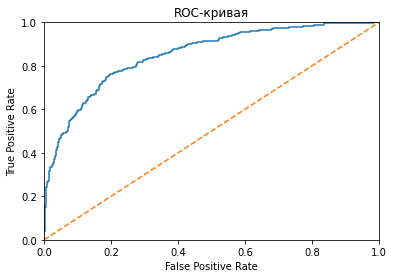

Значение метрики AUC-ROC: 0.851967227713955


In [49]:
probabilities_test = best_model_weight.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()


plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('ROC-кривая')


plt.show()
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print("Значение метрики AUC-ROC:", auc_roc)

**Вывод.** Наша модель справилась с тестированием: F1-мера на тестовой выборке:  0.597544338335607, AUC-ROC: 0.851967227713955.

## Проверка модели на адекватность

Для проверки модели на адекватность сравним предсказания нашей модели с предсказаниями Dummy-классификатора,который делает прогнозы,используя простые правила.

In [50]:
dummy_model =  DummyClassifier(strategy="most_frequent") # предсказывает наиболее частый класс
dummy_model.fit(features_train, target_train)
dummy_predictions = dummy_model.predict(features_test)
dummy_result = accuracy_score(target_test, dummy_predictions)
probabilities = dummy_model.predict_proba(features_test)
probabilities_one = probabilities[:, 1]

print ('Точность модели dummy:', dummy_result)
print ('Точность нашей модели:', best_model_weight.score(features_test, target_test))
print('AUC-ROC модели dummy:', roc_auc_score(target_test, probabilities_one))
print('AUC-ROC нашей модели:', model_auc(best_model_weight, features_test, target_test))

Точность модели dummy: 0.7833974711379879
Точность нашей модели: 0.8378229796591534
AUC-ROC модели dummy: 0.5
AUC-ROC нашей модели: 0.851967227713955


Точность нашей модели выше результатов дамми-классификатора. Это говорит о том, что наша модель прошла проверку на адекватность.

## Вывод

В результате работы была построена модель, выполняющая задачу классификации, предсказывающая факт ухода клиента из банка.

В первую очередь было проведено исследование данных, анализ признаков: на дубликаты, на наличие пропусков, на наличие мультиколлинеарности, на наличие дисбаланса. Затем, данные были масштабированы, категориальные признаки приведены к числовым значениям. Поиск лучшей модели осуществлялся как на сбалансированных данных, так и при дисбалансе. 

В процессе исследования была получена наилучшая модель классификации - модель "Случайный лес" **RandomForestClassifier с параметрами: максимальная глубина дерева - 11, число деревьев - 80.**. Модель показала наилучшие результаты при учете дисбаланса методом  взвешивания классов.

**Метрики лучшей модели RandomForestClassifier:**
- F1-мера на тестовой выборке: 0.597544338335607
- Значение метрики AUC-ROC на тестовой выборке: 0.851967227713955

Модель была проверена на вменяемость: по сравнению со случайными предсказаниями, наша модель показала более точный результат. Это говорит о том, что наша модель прошла проверку на адекватность.